### Identificação de Forças e Fraquezas em aplicativos de Streamming

>Amazon Prime vs Netflix

>Vamos identificar os principais tópicos (temas, assuntos) presentes em:

>>resenhas positivas - de quem gostou! =D

>> resenhas negativas - de quem não curtiu :(

### Importando as bibliotecas necessárias

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('gutenberg')
nltk.download('punkt')
from unicodedata import normalize
from nltk.probability import FreqDist
from gensim import corpora

import re
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import *

In [ ]:
import os
import io
import requests
from pygments.lexers.csound import newline

Montando um gerenciador de arquivos a partir do seu Google Driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd /content/drive/My Drive/DataScience/AnaliseSentimento-App

/content/drive/My Drive/DataScience/AnaliseSentimento-App


In [ ]:
ls

# Coleta dos dados

As resenhas foram exportadas a partir do site "" - esqueci

In [ ]:
import os
arquivos_lista = os.listdir()
resenhas_lista = []
for files_dir in arquivos_lista:
  if "New.csv" in files_dir:
    print(files_dir)

AmazonPrimeVideo_reviews_IOS_New.csv
Netflix_reviews_IOS_New.csv
AmazonPrimeVideo_reviews_Android_New.csv
Netflix_reviews_Android_New.csv


Definindo os dataframes pela leitura das resenhas

In [ ]:
df_amazon_android = pd.read_csv('AmazonPrimeVideo_reviews_Android_New.csv',
                                     encoding='utf-8')

df_amazon_ios = pd.read_csv('AmazonPrimeVideo_reviews_IOS_New.csv',
                                     encoding='utf-8')

df_netflix_android = pd.read_csv('Netflix_reviews_Android_New.csv',
                                     encoding='utf-8')

df_netflix_ios = pd.read_csv('Netflix_reviews_IOS_New.csv',
                                     encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,8,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_amazon_android.head()

,Date,AppID,AppName,Language,Version,VersionCode,OS,Author,Rating,Title,Review,Translated title,Translated review,Reply Date,Developer Reply,User,Device,Device Type,Tags,Categories,Notes,Likes,Dislikes,Link,Permalink,AF Link
0,2020-05-29 02:27:26,com.amazon.avod.thirdpartyclient,Amazon Prime Video,pt,NaN,NaN,NaN,Amanda Ferreira,4,NaN,"Precisa melhorar layout, modo de busca, e o ap...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/98775/review/531413958,https://watch.appfollow.io/apps/untitled-colle...
1,2020-05-29 02:23:41,com.amazon.avod.thirdpartyclient,Amazon Prime Video,pt,NaN,NaN,NaN,Fernanda aparecida lopes de sousa,5,NaN,Filmes muito bons amei !!!!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/98775/review/531413957,https://watch.appfollow.io/apps/untitled-colle...
2,2020-05-29 02:22:10,com.amazon.avod.thirdpartyclient,Amazon Prime Video,pt,NaN,NaN,NaN,Angelo Augusto Tavares Barbosa,3,NaN,"Precisa evoluir, infelizmente, é comum o trava...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/98775/review/531413956,https://watch.appfollow.io/apps/untitled-colle...
3,2020-05-29 02:22:05,com.amazon.avod.thirdpartyclient,Amazon Prime Video,pt,NaN,NaN,NaN,Um usuário do Google,1,NaN,"Horrível, fiz a assinatura agora não consigo a...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/98775/review/531413955,https://watch.appfollow.io/apps/untitled-colle...
4,2020-05-29 02:21:19,com.amazon.avod.thirdpartyclient,Amazon Prime Video,pt,NaN,NaN,NaN,Cristiano Oliveira Nicolau,4,NaN,Muito bom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/98775/review/531413954,https://watch.appfollow.io/apps/untitled-colle...


In [ ]:
df_amazon_ios.head()

,Date,AppID,AppName,Country,Version,Author,Rating,Title,Review,Translated title,Translated review,Reply Date,Developer Reply,User,Tags,Categories,Notes,Likes,Dislikes,Link,Permalink,AF Link
0,2020-05-28 14:00:15,545519333,Amazon Prime Video,br,8.6,Vall2012,5,Curtindo muito,"O aplicativo é ótimo, não trava . Nas series v...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/67144/review/219604317,https://watch.appfollow.io/apps/untitled-colle...
1,2020-05-27 17:24:06,545519333,Amazon Prime Video,br,8.6,AlbDandara,3,"Imagem e som ótimos, porém",A Qualidade de imagem e som é ótima! Filmes at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/67144/review/219484001,https://watch.appfollow.io/apps/untitled-colle...
2,2020-05-27 17:07:12,545519333,Amazon Prime Video,br,8.6,GuiRibeiro,3,Só para aparelhos novos,Não instala nos iPhones e iPads mais antigos. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/67144/review/219484000,https://watch.appfollow.io/apps/untitled-colle...
3,2020-05-27 13:17:23,545519333,Amazon Prime Video,br,8.6,dharielk,3,Uma dúvida,Assinando o amazon prime eu tenho direito a fr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/67144/review/219483999,https://watch.appfollow.io/apps/untitled-colle...
4,2020-05-27 11:30:40,545519333,Amazon Prime Video,br,8.6,joaiznh ramiro,3,Alguns filmes travam,"Muito bom,mas não consigo assistir filmes como...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/67144/review/219483998,https://watch.appfollow.io/apps/untitled-colle...


In [ ]:
df_netflix_android = df_netflix_android.rename(columns={'Unnamed: 8': 'Rating'})
df_netflix_android = df_netflix_android.rename(columns={'Ext_id: com.netflix.mediaclient': 'Date'})
df_netflix_android = df_netflix_android.rename(columns={'Unnamed: 10': 'Review'})

df_netflix_android.drop(df_netflix_android.loc[df_netflix_android['Date']=='Date'].index, inplace=True)



In [ ]:
df_netflix_android.head()

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Rating,Unnamed: 9,Review,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
1,2020-05-29 03:13:46,com.netflix.mediaclient,Netflix,pt,NaN,NaN,NaN,BUTT ZÃO,2,NaN,"Cadê o naruto, em cadê o naruto",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/12115/review/531544120,https://watch.appfollow.io/apps/untitled-colle...
2,2020-05-29 03:11:50,com.netflix.mediaclient,Netflix,pt,NaN,NaN,NaN,sarinha Froes,5,NaN,Ótimo aplicativo! Aprovado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/12115/review/531544119,https://watch.appfollow.io/apps/untitled-colle...
3,2020-05-29 03:10:50,com.netflix.mediaclient,Netflix,pt,NaN,NaN,NaN,Insano Bikes,5,NaN,Tem como eu ir ligação enquanto eu assisto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/12115/review/531544118,https://watch.appfollow.io/apps/untitled-colle...
4,2020-05-29 03:09:36,com.netflix.mediaclient,Netflix,pt,NaN,NaN,NaN,p_gamer,1,NaN,Não estou gostando mais vc's cancelaram lucife...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/12115/review/486851647,https://watch.appfollow.io/apps/untitled-colle...
5,2020-05-29 03:09:32,com.netflix.mediaclient,Netflix,pt,NaN,NaN,NaN,FefeTodin 0404,1,NaN,DEMOROU UMA HORA E MEIA PARA BAIXAR...MAs vale...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...,https://appfollow.io/gp/12115/review/531544117,https://watch.appfollow.io/apps/untitled-colle...


In [ ]:
df_netflix_ios.head()

,Date,AppID,AppName,Country,Version,Author,Rating,Title,Review,Translated title,Translated review,Reply Date,Developer Reply,User,Tags,Categories,Notes,Likes,Dislikes,Link,Permalink,AF Link
0,2020-05-28 20:51:24,363590051,Netflix,br,12.33.2,123 eu Larissa,1,HORRÍVEL HORRÍVEL HORRÍVEL HORRÍVEL,PÉSSIMO BUGADO HORRÍVEL HORRÍVEL \nPÉSSIMO APP...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/8937/review/215784954,https://watch.appfollow.io/apps/untitled-colle...
1,2020-05-28 12:06:41,363590051,Netflix,br,12.33.2,bitcoin pump,1,Classificação,A classificação de idade não desaparece da tela,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/8937/review/219600713,https://watch.appfollow.io/apps/untitled-colle...
2,2020-05-28 10:59:31,363590051,Netflix,br,12.33.2,Zozão,3,É bom,Mas poderia completar as série,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/8937/review/219584161,https://watch.appfollow.io/apps/untitled-colle...
3,2020-05-28 06:02:39,363590051,Netflix,br,12.33.2,damarislucas,1,Série,Voltem a série The Vampaire diaries 😫😩,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/8937/review/219567140,https://watch.appfollow.io/apps/untitled-colle...
4,2020-05-28 03:09:33,363590051,Netflix,br,12.33.2,dsalbuquerque,2,Tem alguém assistindo?,Gente nada é mais irritante do que estar no me...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://itunesconnect.apple.com/WebObjects/iTu...,https://appfollow.io/app/8937/review/219502151,https://watch.appfollow.io/apps/untitled-colle...


# Consolidação do Corpus

### As resenhas de cada SO possuem colunas diferentes no documento com as resenhas

Assim, precisamos normalizar isto, removendo as colunas que não são necessárias para a análise

>Vamos manter as seguintes colunas em ambas os dataframes: 

 >>colunas_alvo = ['Date', 'Rating', 'Review']

In [ ]:
#pegando os nomes das colunas que vamos remover no df amazon android
colunas_alvo = ['Date', 'Rating', 'Review']
colunas_df_android = df_amazon_android.columns
colunas_remocao_android = []
for cols in colunas_df_android:
  if cols not in colunas_alvo:
    colunas_remocao_android.append(cols)
colunas_remocao_android

['AppID',
 'AppName',
 'Language',
 'Version',
 'VersionCode',
 'OS',
 'Author',
 'Title',
 'Translated title',
 'Translated review',
 'Reply Date',
 'Developer Reply',
 'User',
 'Device',
 'Device Type',
 'Tags',
 'Categories',
 'Notes',
 'Likes',
 'Dislikes',
 'Link',
 'Permalink',
 'AF Link']

In [ ]:
df_amazon_android.drop(columns=colunas_remocao_android,
                        inplace=True)

df_amazon_android.head()

,Date,Rating,Review
0,2020-05-29 02:27:26,4,"Precisa melhorar layout, modo de busca, e o ap..."
1,2020-05-29 02:23:41,5,Filmes muito bons amei !!!!
2,2020-05-29 02:22:10,3,"Precisa evoluir, infelizmente, é comum o trava..."
3,2020-05-29 02:22:05,1,"Horrível, fiz a assinatura agora não consigo a..."
4,2020-05-29 02:21:19,4,Muito bom


In [ ]:
#pegando os nomes das colunas que vamos remover no df Netflix android
colunas_alvo = ['Date', 'Rating', 'Review']
colunas_df_android = df_netflix_android.columns
colunas_remocao_android = []
for cols in colunas_df_android:
  if cols not in colunas_alvo:
    colunas_remocao_android.append(cols)
colunas_remocao_android

['Unnamed: 1',
 'Unnamed: 2',
 'Unnamed: 3',
 'Unnamed: 4',
 'Unnamed: 5',
 'Unnamed: 6',
 'Unnamed: 7',
 'Unnamed: 9',
 'Unnamed: 11',
 'Unnamed: 12',
 'Unnamed: 13',
 'Unnamed: 14',
 'Unnamed: 15',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19',
 'Unnamed: 20',
 'Unnamed: 21',
 'Unnamed: 22',
 'Unnamed: 23',
 'Unnamed: 24',
 'Unnamed: 25']

In [ ]:
#removendo as colunas no df android
df_netflix_android.drop(columns=colunas_remocao_android,
                        inplace=True)

df_netflix_android.head()

,Date,Rating,Review
1,2020-05-29 03:13:46,2,"Cadê o naruto, em cadê o naruto"
2,2020-05-29 03:11:50,5,Ótimo aplicativo! Aprovado
3,2020-05-29 03:10:50,5,Tem como eu ir ligação enquanto eu assisto
4,2020-05-29 03:09:36,1,Não estou gostando mais vc's cancelaram lucife...
5,2020-05-29 03:09:32,1,DEMOROU UMA HORA E MEIA PARA BAIXAR...MAs vale...


In [ ]:
#pegando os nomes das colunas que vamos remover no df amazon IOS
colunas_alvo = ['Date', 'Rating', 'Review']
colunas_df_ios = df_amazon_ios.columns
colunas_remocao_ios = []

for cols in colunas_df_ios:
  if cols not in colunas_alvo:
    colunas_remocao_ios.append(cols)

colunas_remocao_ios

['AppID',
 'AppName',
 'Country',
 'Version',
 'Author',
 'Title',
 'Translated title',
 'Translated review',
 'Reply Date',
 'Developer Reply',
 'User',
 'Tags',
 'Categories',
 'Notes',
 'Likes',
 'Dislikes',
 'Link',
 'Permalink',
 'AF Link']

In [ ]:
#removendo as colunas no df IOS
df_amazon_ios.drop(columns=colunas_remocao_ios,
                       inplace=True)
df_amazon_ios.head()

,Date,Rating,Review
0,2020-05-28 14:00:15,5,"O aplicativo é ótimo, não trava . Nas series v..."
1,2020-05-27 17:24:06,3,A Qualidade de imagem e som é ótima! Filmes at...
2,2020-05-27 17:07:12,3,Não instala nos iPhones e iPads mais antigos. ...
3,2020-05-27 13:17:23,3,Assinando o amazon prime eu tenho direito a fr...
4,2020-05-27 11:30:40,3,"Muito bom,mas não consigo assistir filmes como..."


In [ ]:
#pegando os nomes das colunas que vamos remover no df netflix ios
colunas_alvo = ['Date', 'Rating', 'Review']
colunas_df_ios = df_netflix_ios.columns
colunas_remocao_ios = []
for cols in colunas_df_ios:
  if cols not in colunas_alvo:
    colunas_remocao_ios.append(cols)
colunas_remocao_ios




['AppID',
 'AppName',
 'Country',
 'Version',
 'Author',
 'Title',
 'Translated title',
 'Translated review',
 'Reply Date',
 'Developer Reply',
 'User',
 'Tags',
 'Categories',
 'Notes',
 'Likes',
 'Dislikes',
 'Link',
 'Permalink',
 'AF Link']

In [ ]:
#removendo as colunas no df IOS

df_netflix_ios.drop(columns=colunas_remocao_ios,
                       inplace=True)

df_netflix_ios.head()

,Date,Rating,Review
0,2020-05-28 20:51:24,1,PÉSSIMO BUGADO HORRÍVEL HORRÍVEL \nPÉSSIMO APP...
1,2020-05-28 12:06:41,1,A classificação de idade não desaparece da tela
2,2020-05-28 10:59:31,3,Mas poderia completar as série
3,2020-05-28 06:02:39,1,Voltem a série The Vampaire diaries 😫😩
4,2020-05-28 03:09:33,2,Gente nada é mais irritante do que estar no me...


Unindo os df Androi e IOS para analisarmos inicialmente apenas o PRODUTO, ie a aplicação em si, 

e não o comportamento deles nos respectivos SO's

Amazon

In [ ]:
print("Tamanho do Dataframe Amazon Android: {0}".format(len(df_amazon_android)))
print("Tamanho do Dataframe Amazon IOS: {0}".format(len(df_amazon_ios)))

#comando append para unir as linhas dos dois dataframes
#append concatena logo apos a ultima linha
relacao_colunas = {'Date':'Date', 'Rating':'Rating', 'Review':'Review'}

df_amazon_concat = pd.concat([df_amazon_android, df_amazon_ios.rename(columns=relacao_colunas)])

#validando união das linhas no novo df
assert len(df_amazon_concat) == len(df_amazon_android)+len(df_amazon_ios)

#Validando o numero de colunas do novo df 
assert len(df_amazon_concat.columns) == 3

print("Tamanho Total do Dataframe Amazon : {0}".format(len(df_amazon_concat)))

Tamanho do Dataframe Amazon Android: 22755
Tamanho do Dataframe Amazon IOS: 1485
Tamanho Total do Dataframe Amazon : 24240


In [ ]:
# df_amazon_concat.to_csv("df_amazon_concat.csv") 
df_amazon_concat['Review'][2]

2    Precisa evoluir, infelizmente, é comum o trava...
2    Não instala nos iPhones e iPads mais antigos. ...
Name: Review, dtype: object

Netflix

In [ ]:
print("Tamanho do Dataframe Amazon Android: {0}".format(len(df_netflix_android)))
print("Tamanho do Dataframe Amazon IOS: {0}".format(len(df_netflix_ios)))

#comando append para unir as linhas dos dois dataframes
relacao_colunas = {'Date':'Date', 'Rating':'Rating', 'Review':'Review'}

df_netflix_concat = pd.concat([df_netflix_android, df_netflix_ios.rename(columns=relacao_colunas)])

# #validando união das linhas no novo df
assert len(df_netflix_concat) == len(df_netflix_android)+len(df_netflix_ios)

# #Validando o numero de colunas do novo df 
assert len(df_netflix_concat.columns) == 3

print("Tamanho Total do Dataframe Amazon : {0}".format(len(df_netflix_concat)))

Tamanho do Dataframe Amazon Android: 50000
Tamanho do Dataframe Amazon IOS: 9436
Tamanho Total do Dataframe Amazon : 59436


In [ ]:
#df_netflix_concat.to_csv("df_netflix_concat.csv") 


# Lendo os dataframes das bases consolidadas - seguir daqui

In [ ]:
df_netflix_full_concat = pd.read_csv('df_netflix_concat.csv',
                                     encoding='utf-8')
df_netflix_full_concat['Review'][9436]

'Voltaaaaaaa Naruto dubladooooooooooooooo !!!!!!!!?'

In [ ]:
df_amazon_full_concat = pd.read_csv('df_amazon_concat.csv',
                                     encoding='utf-8')
df_amazon_full_concat['Review'][2]

'Precisa evoluir, infelizmente, é comum o travamento das legendas, em especial, no app da smartv, além de alguns conteúdos não terem a opção de dublagem na nossa língua nativa (pt-br). O Menu pode ser mais intuitivo e a interface pode ser melhor trabalhada. Ponto positivo é a edição de cores e tamanhos de legenda, filmografia e link com o IMDB..'

# Funções de Pré-processamento do conteudo de texto das resenhas


In [ ]:
# -*- coding: utf-8 -*-


caminho_stopwords = "/content/drive/MyDrive/DataScience/AnaliseSentimento-App/stopwords.txt"
def to_string(alist):
  seperator = ' '
  raw_text = seperator.join(alist)
  return raw_text
  
def obter_lista_novas_stopwords(caminho_stopwords):
  novas_stopwords = []
  # print("\n*************************************************************************\n")
  # print("Extraindo StopWords ...\n")
  try:
      arquivo_stopwords = open(caminho_stopwords, "r", encoding="utf-8")
      for linha in arquivo_stopwords:
          linha = linha.strip()
          novas_stopwords.append(linha)
  except:
      print("Erro na extração de StopWords! \n")
  finally:
      arquivo_stopwords.close()
      # print("Extração das stopWords realizada com sucesso! \n")
      # print("*************************************************************************\n")
  return novas_stopwords


In [1]:
ls

sample_data/


In [ ]:
# -*- coding: utf-8 -*-


def remover_stopwords(texto):
  stop_words = set(stopwords.words('portuguese'))
  stop_words_us = set(stopwords.words('english'))
  #new_stopwords = obter_lista_novas_stopwords(caminho_stopwords)
  #stop_words.update(new_stopwords)
  #stop_words.update([stp.lower() for stp in new_stopwords])
  stop_words.update(stop_words_us)
  palavras_uteis = [palavra for palavra in texto.lower().split() if palavra not in stop_words]
  return ' '.join(palavras_uteis)

def tokenizar_texto(texto):
  texto_tokenizado = word_tokenize(texto.lower())
  return texto_tokenizado

def remover_acentos(texto):
  return normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')

def converter_texto_para_minusculo(texto):
  return texto.lower()

def remover_caracteres_especiais(texto):
  texto_sem_carac_esp = re.sub(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕàÀìÌòÒïÏñÑÜüçÇ ]', "", texto)
  return texto_sem_carac_esp

def remover_email(texto):
  padrao_email = r'[\w+\./{1}]+@(?:[a-zA-Z0-9-]+\.)+[a-zA-Z]{2,}'
  texto_sem_email = re.sub(padrao_email, "", texto)
  return texto_sem_email

def remover_conjunto_emails(texto):
  padrao_email = r'\{[\w+\./{1}\,*]+\}@(?:[a-zA-Z0-9-]+\.)+[a-zA-Z]{2,}'
  texto_sem_email = re.sub(padrao_email, "", texto)
  return texto_sem_email

def remover_enderecos_emails(texto):
  texto = remover_conjunto_emails(texto)
  texto = remover_email(texto)
  return texto

def remover_url(texto):
  padrao_url = r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*'
  texto_sem_url = re.sub(padrao_url, "", str(texto))
  return texto_sem_url


def remover_numeros(texto):
  texto_sem_numeros = re.sub(r'\d', "", texto)
  return texto_sem_numeros

def remover_caracteres_especiais(texto):
  texto_sem_carac_esp = re.sub(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕàÀÜüçÇ ]', "", texto)
  return texto_sem_carac_esp

def remover_sequencia_espaco_branco(texto):
  padrao = re.compile(r"(\s)\1{1,}")
  return padrao.sub(r"\1", texto)

def remover_palavras_por_tamanho(texto, limite):
  lista_texto = tokenizar_texto(texto)
  lista_palavras_retorno = []
  separador = ' '
  for palavra in lista_texto:
      if len(palavra) > limite:
          lista_palavras_retorno.append(palavra)
  texto_pos_remocao = separador.join(lista_palavras_retorno)
  return texto_pos_remocao

def unificar_artigos_com_n_gramas(lista_de_lista_de_texto):
  artigo_tokens_unificados = []
  for texto in lista_de_lista_de_texto:
      xtexto = texto
      unigramas = xtexto
      xbigramas = construir_bigramas(xtexto)
      xtrigramas = construir_trigramas(xtexto)
      xunigramas = unigramas + xbigramas + xtrigramas
      artigo_tokens_unificados.append(xunigramas)
  return artigo_tokens_unificados

def construir_bigramas(texto_tokenizado):
  bigrams = []
  for i in range(0, len(texto_tokenizado)):
      if (i == len(texto_tokenizado) - 1):
          break
      else:
          bigrama_obs = texto_tokenizado[i] + '_' + texto_tokenizado[i + 1]
          bigrams.append(bigrama_obs)
  # colocar analise por frequencia aqui
  bigrams = remover_ngram_por_frequencia(bigrams, 7)
  return bigrams

def construir_trigramas(texto_tokenizado):
  trigrams = []
  for i in range(0, len(texto_tokenizado)):
      if (i == len(texto_tokenizado) - 2):
          break
      else:
          trigrama_obs = texto_tokenizado[i] + '_' + texto_tokenizado[i + 1] + '_' + texto_tokenizado[i + 2]
          trigrams.append(trigrama_obs)
  # colocar analise por frequencia aqui
  trigrams = remover_ngram_por_frequencia(trigrams, 7)
  return trigrams

def remover_ngram_por_frequencia(lista_ngrams, frequencia_limiar):
  fdist = FreqDist(lista_ngrams)
  lista_ngrams_retorno = [w for w in lista_ngrams if fdist[w] >= frequencia_limiar]
  return lista_ngrams_retorno

def obter_dicionario(lista_de_lista_textos):
  dic_id_palavras = corpora.Dictionary(lista_de_lista_textos)
  return dic_id_palavras

def obter_corpus(dicionario_texto, lista_de_lista_texto):
  corpus_texto = [dicionario_texto.doc2bow(lista_texto) for lista_texto in lista_de_lista_texto]
  return corpus_texto


def remover_hashtags(text):
  raw = re.sub(r'#[A-Za-z0-9]+', "", text)
  return raw

def remover_repeticao_letras(text):
  pattern = re.compile(r"(.)\1{2,}")
  return pattern.sub(r"\1", text)

def traduzir_emoticons(text):
  text = re.sub(r'\:\)|\(\:|\=\)|\(\=|\:D', "sorrindo", text)
  text = re.sub(r'D\:', "surpreso", text)
  text = re.sub(r'\;\)|\(\;', "piscando", text)
  text = re.sub(r'xd', "sorrindo", text)
  text = re.sub(r'\:O', "surpreso", text)
  text = re.sub(r'<2|<3|s2|sz|s3', "amor", text)
  text = re.sub(r'u.u', "prevalecido", text)
  text = re.sub(r'\:\/', "indeciso", text)
  text = re.sub(r'\:\'\(', "chorando", text)
  text = re.sub(r'\:9', "gostando", text)
  text = re.sub(r'\:x', "aborrecido", text)
  text = re.sub(r'\*\-\*', "gostando", text)
  return text

def tradutor_abreveacao(text):
  text = re.sub(r'blz', "beleza", text)
  text = re.sub(r'flw', "tchau", text)
  text = re.sub(r'vlw', "obrigado", text)
  text = re.sub(r'ta', "esta", text)
  text = re.sub(r'mt', "muito", text)
  text = re.sub(r'mts', "muitos", text)
  text = re.sub(r'mó', "muito", text)
  text = re.sub(r'pf', "por favor", text)
  text = re.sub(r'mlhr', "melhor", text)
  text = re.sub(r'q', "que", text)
  text = re.sub(r'n', "não", text)
  text = re.sub(r's', "sim", text)
  text = re.sub(r'pq', "porque", text)
  text = re.sub(r'ok', "beleza", text)
  text = re.sub(r'vcs', "voces", text)
  text = re.sub(r'vc', "voce", text)
  text = re.sub(r'amr', "amor", text)
  text = re.sub(r'migo', "amigo", text)
  text = re.sub(r'migs', "amigo", text)
  text = re.sub(r'okz', "beleza", text)
  text = re.sub(r'hj', "hoje", text)
  text = re.sub(r'p|p\/', "para", text)
  return text

def tokenizar_tweets(text):
  tweet_tokenizer =  TweetTokenizer(strip_handles=True, reduce_len=False, preserve_case=False)
  return tweet_tokenizer.tokenize(text)

def converter_termos_geral(texto):
  texto = re.sub(" app"," aplicativo ",texto)
  texto = re.sub('blz ', " beleza ", texto)
  texto = re.sub('ta ', " esta ", texto)
  texto = re.sub('mt', " muito ", texto)
  texto = re.sub('mts', " muitos ", texto)
  texto = re.sub('mó ', " muito ", texto)
  texto = re.sub(' pf ', " por favor ", texto)
  texto = re.sub(' mlhr ', " melhor ", texto)
  texto = re.sub(' q ', " que ", texto)
  texto = re.sub(' n ', " não ", texto)
  texto = re.sub(' s ', " sim ", texto)
  texto = re.sub(' pq ', " porque ", texto)
  texto = re.sub(' vcs ', " voces ", texto)
  texto = re.sub(' vc ', " voce ", texto)
  texto = re.sub(' amr ', " amor ", texto)
  texto = re.sub(' hj ', " hoje ", texto)
  texto = texto.lstrip()
  return texto.rstrip()


def pre_processamento_dados(texto):
  texto = str(texto)
  texto = remover_url(texto)
  texto = remover_hashtags(texto)
  texto = remover_numeros(texto)
  texto = converter_termos_geral(texto)
  texto = traduzir_emoticons(texto)
  texto = remover_palavras_por_tamanho(texto, 1)
  texto = remover_stopwords(texto)
  #texto = tokenizar_tweets(texto)
  texto = remover_repeticao_letras(texto)
  texto = remover_acentos(texto)
  texto = remover_caracteres_especiais(texto)
  texto = remover_sequencia_espaco_branco(texto)
  texto = remover_hashtags(texto)
  return texto

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preparando o corpus para o treinamento

In [ ]:
df_amazon_full_concat['Classification'] = 'NaN'
df_netflix_full_concat['Classification'] = 'NaN'

In [ ]:
df_amazon_full_concat.head()


,Unnamed: 0,Date,Rating,Review,Classification
0,0,2020-05-29 02:27:26,4,"Precisa melhorar layout, modo de busca, e o ap...",NaN
1,1,2020-05-29 02:23:41,5,Filmes muito bons amei !!!!,NaN
2,2,2020-05-29 02:22:10,3,"Precisa evoluir, infelizmente, é comum o trava...",NaN
3,3,2020-05-29 02:22:05,1,"Horrível, fiz a assinatura agora não consigo a...",NaN
4,4,2020-05-29 02:21:19,4,Muito bom,NaN


In [ ]:
df_netflix_full_concat.head()

,Unnamed: 0,Date,Rating,Review,Classification
0,1,2020-05-29 03:13:46,2,"Cadê o naruto, em cadê o naruto",NaN
1,2,2020-05-29 03:11:50,5,Ótimo aplicativo! Aprovado,NaN
2,3,2020-05-29 03:10:50,5,Tem como eu ir ligação enquanto eu assisto,NaN
3,4,2020-05-29 03:09:36,1,Não estou gostando mais vc's cancelaram lucife...,NaN
4,5,2020-05-29 03:09:32,1,DEMOROU UMA HORA E MEIA PARA BAIXAR...MAs vale...,NaN


In [ ]:
print("Df netflix antes de remover linhas duplicas: {}".format(len(df_netflix_full_concat)))
print("Df amazon antes de remover linhas duplicas: {}".format(len(df_amazon_full_concat)))

Df netflix antes de remover linhas duplicas: 59436
Df amazon antes de remover linhas duplicas: 24240


In [ ]:
# Removendo os valores duplicados:
df_netflix_full_concat.drop_duplicates(['Review'], inplace=True)
df_amazon_full_concat.drop_duplicates(['Review'], inplace=True)

In [ ]:
print("Df netflix depois de remover linhas duplicas: {}".format(len(df_netflix_full_concat)))
print("Df amazon depois de remover linhas duplicas: {}".format(len(df_amazon_full_concat)))

Df netflix depois de remover linhas duplicas: 41683
Df amazon depois de remover linhas duplicas: 19026


### Classificando a coluna de sentimento (Classificação)
Vamos rotular as resenhas de acordo com o Rating:
- dentro de [1,2] --> Negativa
- dentro de [4,5] --> Positiva
- Mas e as resenhas com Rating igual a 3?

In [ ]:
for index, row in df_amazon_full_concat.iterrows():
  if str(row['Rating']) in ['1', '2']:
    df_amazon_full_concat.loc[index,'Classification'] = "Negativa"
  if str(row['Rating']) in ['4', '5']:
    df_amazon_full_concat.loc[index,'Classification'] = "Positiva"

In [ ]:
for index, row in df_netflix_full_concat.iterrows():
  if str(row['Rating']) in ['1', '2']:
    df_netflix_full_concat.loc[index,'Classification'] = "Negativa"
  if str(row['Rating']) in ['4', '5']:
    df_netflix_full_concat.loc[index,'Classification'] = "Positiva"

In [ ]:
df_amazon_full_concat.Classification

0        Positiva
1        Positiva
2             NaN
3        Negativa
4        Positiva
           ...   
24235    Negativa
24236    Positiva
24237    Negativa
24238         NaN
24239    Negativa
Name: Classification, Length: 19026, dtype: object

In [ ]:
df_netflix_full_concat.Classification

0        Negativa
1        Positiva
2        Positiva
3        Negativa
4        Negativa
           ...   
59431    Negativa
59432         NaN
59433    Positiva
59434    Positiva
59435    Positiva
Name: Classification, Length: 41683, dtype: object

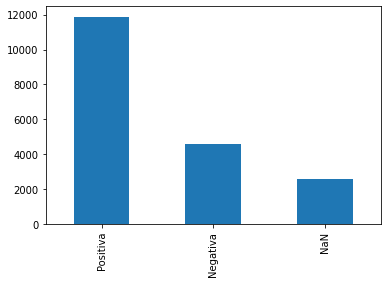

In [ ]:
df_amazon_full_concat.Classification.value_counts().plot(kind='bar', )

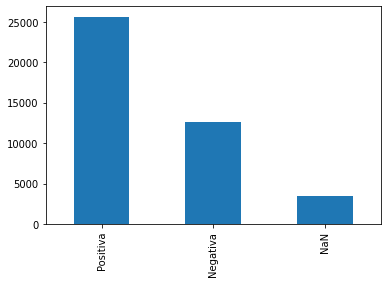

In [ ]:
df_netflix_full_concat.Classification.value_counts().plot(kind='bar')

### Separando a base classificada e não classificada
- Elas serão usadas no treinamento do modelo e no teste do modelo
- Ponto de discussão: Será que faz sentido adotar a classificação automática? 
Quantas resenhas não-classificadas nós temos?

In [ ]:
df_amazon_rotulado =  df_amazon_full_concat.query('Classification != "NaN"')
df_amazon_nao_rotulado =  df_amazon_full_concat.query('Classification == "NaN"')
print("Tamanho do Dataframe Amazon Rotulado: {0}".format(len(df_amazon_rotulado)))
print("Tamanho do Dataframe Amazon Não Rotulado: {0}".format(len(df_amazon_nao_rotulado)))

Tamanho do Dataframe Amazon Rotulado: 16447
Tamanho do Dataframe Amazon Não Rotulado: 2579


In [ ]:
len(df_amazon_nao_rotulado)

2579

In [ ]:
df_netflix_rotulado =  df_netflix_full_concat.query('Classification != "NaN"')
df_netflix_nao_rotulado =  df_netflix_full_concat.query('Classification == "NaN"')
print("Tamanho do Dataframe Netflix Rotulado: {0}".format(len(df_netflix_rotulado)))
print("Tamanho do Dataframe Netflix Não Rotulado: {0}".format(len(df_netflix_nao_rotulado)))

Tamanho do Dataframe Netflix Rotulado: 38239
Tamanho do Dataframe Netflix Não Rotulado: 3444


In [ ]:
len(df_netflix_nao_rotulado)

3444

### Separando as resenhas das classes

In [ ]:
resenhas_amazon = df_amazon_rotulado['Review']
classes_amazon = df_amazon_rotulado['Classification']


In [ ]:
resenhas_netflix = df_netflix_rotulado['Review']
classes_netflix = df_netflix_rotulado['Classification']


### Realizando o pre-processamento nas resenhas

In [ ]:
resenhas_lista_amazon = [pre_processamento_dados(i).lstrip().rstrip() for i in resenhas_amazon]


In [ ]:
resenhas_lista_netflix = [pre_processamento_dados(i).lstrip().rstrip() for i in resenhas_netflix]

In [ ]:
resenhas_lista_amazon[:10]

['precisa melhorar layout modo busca aplicativo smart tv consigo colocar portprevalecidoes',
 'filmes bons amei',
 'horrivel fiz assinatura agora consigo assistir nenhum filme',
 'bom',
 'rapido seguro',
 'mt bom',
 'ter catalogo abrangente series',
 'deviam deixar intuitivo usar netflix oq odio tela aumento voce aper vez ai trocar qualquer coisa legenda volume vol normal horrivel',
 'previas intrusivas deveriam tocar automaticamente',
 'gostando filmes series antigas otimas faltando faroestes somente k']

In [ ]:
resenhas_lista_netflix[:10]

['cade naruto cade naruto',
 'otimo aplicativo aprovado',
 'ir ligacao enquanto assisto',
 'gostando vc s cancelaram lucifer causa outra serie fiquei triste vc s causa verdade vem tona',
 'demorou hora meia baixar valeu apena',
 'amei',
 'fal adiciona muitos filmes acao assisti tantos obrigado assistir novo',
 'adoro assistir filme',
 'melhor aplicativo pra olhar filmes series super recomendado ainda pode abaixar filme seri incrivel aplicativo parabens desevonvedores amei demais aplicativo',
 'fantastica permite possa viajar dimensoes espetaculares quaisquer lugares queira bem situacoes extremamente aterrorizantes emocionantes show']

In [ ]:
resenhas_vazias= 0
for res in resenhas_lista:
  if len(res) ==0:
    resenhas_vazias = resenhas_vazias +1
percent_resenhas_vazias = resenhas_vazias/len(resenhas_lista)
print("Resenhas Vazias: {0}%".format(round(percent_resenhas_vazias*100, 2)))

Resenhas Vazias: 0.54%


# Criando o modelo

### vetorização dos textos

In [ ]:
tweet_tokenizer = TweetTokenizer()
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

Vetorizando os dados
- cada palavra se torna uma coluna - matriz de termo-frequencia
- ponto de atenção - Uso do vectorizer.transform() e o vectorizer.fit_transform() 

In [ ]:
freq_resenhas_amazon = vectorizer.fit_transform(resenhas_lista_amazon)
freq_resenhas_netflix = vectorizer.fit_transform(resenhas_lista_netflix)

Dados vetorizados em uma matriz esparsa, de "0" e "1"

In [ ]:
type(freq_resenhas_amazon)

scipy.sparse.csr.csr_matrix

In [ ]:
freq_resenhas_amazon.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Tamanho das matrizes esparsas de Termo-Frequencia criadas após a vetorização

In [ ]:
tp_matrix_am = freq_resenhas_amazon.shape
tp_matrix_nt = freq_resenhas_netflix.shape

print("Dimensões da Matriz Esparsa do Df Amazon: {0} linhas x {1} colunas".format(tp_matrix_am[1], tp_matrix_am[0]))
print("Dimensões da Matriz Esparsa do Df Netflix: {0} linhas x {1} colunas".format(tp_matrix_nt[1], tp_matrix_nt[0]))


Dimensões da Matriz Esparsa do Df Amazon: 10971 linhas x 16447 colunas
Dimensões da Matriz Esparsa do Df Netflix: 19364 linhas x 38239 colunas


### Treino do Modelo

In [ ]:
modelo_amazon = MultinomialNB()
modelo_amazon.fit(freq_resenhas_amazon, classes_amazon)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
modelo_netflix = MultinomialNB()
modelo_netflix.fit(freq_resenhas_netflix, classes_netflix)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Verificando o modelo com uma frase de teste

In [ ]:
teste = ['possui excelentes series precisa melhorar a busca',
         'estou muito feliz com o aplicativo',
         'não estou muito feliz com o aplicativo',
         'aplicativo não abre e lento']

In [ ]:
teste = [pre_processamento_dados(i).lstrip().rstrip() for i in teste]

In [ ]:
freq_teste = vectorizer.transform(teste)

Modelo Netflix

In [ ]:
for t,c in zip(teste, modelo_netflix.predict(freq_teste)):
  print(t + ", " + c)

possui excelentes series precisa melhorar busca, Positiva
feliz aplicativo, Positiva
feliz aplicativo, Positiva
aplicativo abre lento, Negativa


In [ ]:
# Detalhando a prob. da predição
modelo_netflix.predict_proba(freq_teste).round(2)

array([[0.02, 0.98],
       [0.06, 0.94],
       [0.06, 0.94],
       [0.97, 0.03]])

Modelo Amazon

In [ ]:
for t,c in zip(teste, modelo_amazon.predict(freq_teste)):
  print(t + ", " + c)

ValueError: ignored

In [ ]:
# Detalhando a prob. da predição
modelo_amazon.predict_proba(freq_teste).round(2)

array([[0.  , 1.  ],
       [0.04, 0.96],
       [0.04, 0.96],
       [0.88, 0.12]])

# Definindo um Pipeline automatizado para gerar o modelo

Etapas do Pipiline Simples






In [ ]:
etapas = [('counts', CountVectorizer()),
          ('classifier', MultinomialNB())]


In [ ]:
pipeline_amazon = Pipeline(etapas)
pipeline_netflix = Pipeline(etapas)

Treinando os Pipelines

In [ ]:
pipeline_amazon.fit(resenhas_lista_amazon, classes_amazon)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
pipeline_netflix.fit(resenhas_lista_netflix, classes_netflix)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
pipeline_amazon.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

Pipeline de Modelo SVM
- Kernel Linear


Etapas do Pipilene SVM

In [ ]:
etapas_svm = [('count', CountVectorizer()),
              ('classifier',svm.SVC(kernel='linear'))]

In [ ]:
pipeline_svm_amazon = Pipeline(etapas_svm)
pipeline_svm_netflix = Pipeline(etapas_svm)

# Validando os modelos
- Validação Cruzada - de 10 folds - cv=10

In [ ]:
resultados_modelo_amazon = cross_val_predict(pipeline_amazon, resenhas_lista_amazon, classes_amazon, cv=10)
resultados_modelo_netflix = cross_val_predict(pipeline_netflix, resenhas_lista_netflix, classes_netflix, cv=10)


* Medindo a métrica de acurácia dos modelos


In [ ]:
accur_pipeline_amazon = accuracy_score(classes_amazon, resultados_modelo_amazon)
print("Acurácia do Modelo Pipeline Simples Amazon: {0}".format((accur_pipeline_amazon)))

accur_pipeline_netflix = accuracy_score(classes_netflix, resultados_modelo_netflix)
print("Acurácia do Modelo Pipeline Simples Netflix: {0}".format((accur_pipeline_netflix)))

Acurácia do Modelo Pipeline Simples Amazon: 0.8866662613242536
Acurácia do Modelo Pipeline Simples Netflix: 0.8631501869818772


Medidas de Validação do Modelo

* Acurácia: proximidade entre o valor obtido no modelo e o valor verdadeiro na classificação rotulada 





Amazon

In [ ]:
# Acurácia
sentimentos = ['Positiva', 'Negativa']
print(classification_report(classes_amazon, resultados_modelo_amazon, sentimentos))

              precision    recall  f1-score   support

    Positiva       0.92      0.93      0.92     11875
    Negativa       0.81      0.78      0.79      4572

    accuracy                           0.89     16447
   macro avg       0.86      0.85      0.86     16447
weighted avg       0.89      0.89      0.89     16447



Netflix

In [ ]:
# Acurácia
sentimentos = ['Positiva', 'Negativa']
print(classification_report(classes_netflix, resultados_modelo_netflix, sentimentos))

              precision    recall  f1-score   support

    Positiva       0.89      0.91      0.90     25620
    Negativa       0.81      0.76      0.79     12619

    accuracy                           0.86     38239
   macro avg       0.85      0.84      0.84     38239
weighted avg       0.86      0.86      0.86     38239



* Matriz de Confusão: Avaliar no número de predições erradas por classe (feature)

Amazon


In [ ]:
print(pd.crosstab(classes_amazon, resultados_modelo_amazon, rownames=['Real'], colnames=['Predito'],  margins=True))

Predito   Negativa  Positiva    All
Real                               
Negativa      3564      1008   4572
Positiva       856     11019  11875
All           4420     12027  16447


In [ ]:
print(pd.crosstab(classes_netflix, resultados_modelo_netflix, rownames=['Real'], colnames=['Predito'],  margins=True))

Predito   Negativa  Positiva    All
Real                               
Negativa      9580      3039  12619
Positiva      2194     23426  25620
All          11774     26465  38239


In [ ]:
def obter_metricas(modelo, resenhas, classes):
  resutado = cross_val_predict(modelo, resenhas, classes,cv=10)
  return accuracy_score(classes, resutado)
  

In [ ]:
# naive bayes simples
accur_pp_amazon = obter_metricas(pipeline_amazon, resenhas_lista_amazon, classes_amazon)
accur_pp_netflix = obter_metricas(pipeline_netflix, resenhas_lista_netflix, classes_netflix)

print("Acurácia do modelo Naive Bayes - Amazon: {}".format(accur_pp_amazon))
print("Acurácia do modelo Naive Bayes - Netflix {}".format(accur_pp_netflix))

Acurácia do modelo Naive Bayes - Amazon: 0.8866662613242536
Acurácia do modelo Naive Bayes - Netflix 0.8631501869818772


In [ ]:
# SVM
accur_pp_svm_amazon = obter_metricas(pipeline_svm_amazon, resenhas_lista_amazon, classes_amazon)
accur_pp_svm_netflix = obter_metricas(pipeline_svm_netflix, resenhas_lista_netflix, classes_netflix)

print("Acurácia do modelo SVM - Amazon: {}".format(accur_pp_svm_amazon))
print("Acurácia do modelo SVM - Netflix: {}".format(accur_pp_svm_netflix))


Acurácia do modelo SVM - Amazon: 0.8847206177418374
Acurácia do modelo SVM - Netflix: 0.8595151546850075


# Predição aplicada na Base de Dados
- Vamos classificar as resenhas não-Classificadas 
- Para separar as bases (Positiva e Negativa) que usaremos na Modelagem de Tópicos

---
 ToDo List
* Criar metodo para pre-processar uma string  e retornar string pre-processada
* Criar método para predizer as resenhas não-classificadas diretamente nos Dfs
* Concatenar e depois consolidar os Dfs classificados e nao-classificados
* Separar resenhas classificadas entre Positivas e Negativas
* Consolidar resenhas separadas em arquivo .txt




In [ ]:
# ToDo List
# Criar método para predizer as resenhas não-classificadas diretamente nos Dfs
# Separar resenhas classificadas entre Positivas e Negativas
# Consolidar resenhas separadas em arquivo .txt

In [ ]:
df_net_nao_rotulado.head()

,Unnamed: 0,Date,Rating,Review,Classification
2,2,2020-05-29 02:22:10,3,"Precisa evoluir, infelizmente, é comum o trava...",Positiva
11,11,2020-05-29 02:02:55,3,O ap é bom temuitos filmes e seres mais deixa ...,Positiva
14,14,2020-05-29 01:42:12,3,É ruim o fato da minha lista ficar junto com o...,Positiva
30,30,2020-05-29 01:01:36,3,"Precisa ter trailer dos filmes, quando temos o...",Positiva
33,33,2020-05-29 00:49:23,3,Muitos filmes dublados! Lamentável,Negativa


In [ ]:
df_netflix_nao_rotulado.head()

,Unnamed: 0,Date,Rating,Review,Classification
48,49,2020-05-29 02:04:55,3,Tem algumas séries com temporada faltando,NaN
103,104,2020-05-29 01:06:31,3,Não esta favorável a mim pq as séries q eu gos...,NaN
133,134,2020-05-29 00:03:21,3,Ele é ótimo só que está tirando muitos filmes ...,NaN
147,148,2020-05-28 23:48:42,3,"Vou dar três estrelas, por ter descontado assi...",NaN
186,187,2020-05-28 23:12:25,3,O app é bom pq tem varios filmes e series e da...,NaN


Classificando resenhas não-rotuladas com o modelo Netflix

In [ ]:
count = 0
for index, row in df_netflix_nao_rotulado.iterrows():
  resenha = row['Review']
  resenha = pre_processamento_dados(resenha)
  if (not(resenha.isspace()) and len(resenha) > 1):
    lista_resenha = []
    lista_resenha.append(resenha)
    classificacao_pred = pipeline_netflix.predict(lista_resenha)[0]
    df_netflix_nao_rotulado.loc[index,'Classification'] = classificacao_pred
    #print("{0},{1},{2}".format(index, resenha,  classificacao_pred))
    count = count+1


print(count)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


3419


In [ ]:
len(df_netflix_nao_rotulado)

3444

Classificando resenhas não-rotuladas com o modelo Amazon

In [ ]:
count = 0
for index, row in df_amazon_nao_rotulado.iterrows():
  resenha = row['Review']
  resenha = pre_processamento_dados(resenha)
  if (not(resenha.isspace()) and len(resenha) > 1):
    lista_resenha = []
    lista_resenha.append(resenha)
    classificacao_pred = pipeline_amazon.predict(lista_resenha)[0]
    df_amazon_nao_rotulado.loc[index,'Classification'] = classificacao_pred
    #print("{0},{1},{2}".format(index, resenha,  classificacao_pred))
    count = count+1


print(count)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


2577


In [ ]:
len(df_amazon_nao_rotulado)

2579

In [ ]:
ls

In [ ]:
df_amazon_nao_rotulado.head()

,Unnamed: 0,Date,Rating,Review,Classification
2,2,2020-05-29 02:22:10,3,"Precisa evoluir, infelizmente, é comum o trava...",Positiva
11,11,2020-05-29 02:02:55,3,O ap é bom temuitos filmes e seres mais deixa ...,Positiva
14,14,2020-05-29 01:42:12,3,É ruim o fato da minha lista ficar junto com o...,Positiva
30,30,2020-05-29 01:01:36,3,"Precisa ter trailer dos filmes, quando temos o...",Positiva
33,33,2020-05-29 00:49:23,3,Muitos filmes dublados! Lamentável,Negativa


In [ ]:
df_netflix_nao_rotulado.head()

,Unnamed: 0,Date,Rating,Review,Classification
48,49,2020-05-29 02:04:55,3,Tem algumas séries com temporada faltando,Positiva
103,104,2020-05-29 01:06:31,3,Não esta favorável a mim pq as séries q eu gos...,Positiva
133,134,2020-05-29 00:03:21,3,Ele é ótimo só que está tirando muitos filmes ...,Positiva
147,148,2020-05-28 23:48:42,3,"Vou dar três estrelas, por ter descontado assi...",Positiva
186,187,2020-05-28 23:12:25,3,O app é bom pq tem varios filmes e series e da...,Positiva


In [ ]:
df_amazon_nao_rotulado.to_csv("df_amazon_rotulada_modelo.csv") 
df_netflix_nao_rotulado.to_csv("df_netflix_rotulada_modelo.csv") 